# Dynamic PCA followed by linear classification (Logistic regression and SVM)

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [17]:
# Load data from Day-2
df_sheet1 = pd.read_excel("P:/Fall 2023/CHE 660/Project/Testday2_merged.xlsx", sheet_name="Day2")

# Load data from Day-3
df_sheet2 = pd.read_excel("P:/Fall 2023/CHE 660/Project/Testday2_merged.xlsx", sheet_name="Day3")

# Load data from Day-4
df_sheet3 = pd.read_excel("P:/Fall 2023/CHE 660/Project/Testday2_merged.xlsx", sheet_name="Day4")

# Concatenate the data
df_combined = pd.concat([df_sheet1, df_sheet2, df_sheet3], ignore_index=True)

# Extract features (columns 2-15) and labels (column 16)
process_data = df_combined.iloc[:, 1:15]  # Assuming columns are 0-indexed
condition = df_combined.iloc[:, 15]

In [18]:
# User-defined lag
lag = 3  # You can change this to any desired lag value

# Create a lagged matrix
lagged_matrix = pd.concat([process_data.shift(i) for i in range(lag + 1)], axis=1)

# Drop rows with NaN values introduced by shifting
lagged_matrix = lagged_matrix.dropna()

# Reset the index if needed
lagged_matrix.reset_index(drop=True, inplace=True)

# Mean center and scale the lagged matrix
scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(lagged_matrix)

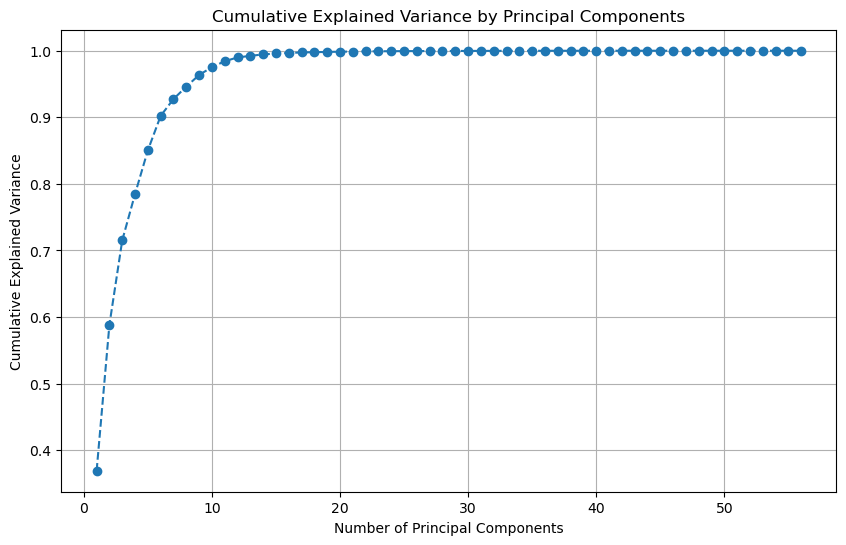

Number of components capturing 90% of the variance: 6


In [19]:
# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_matrix)

# Plot the variance explained by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


# Determine the number of principal components that capture 90% of the variance
target_explained_variance = 0.90
n_components = next(i for i, cum_var in enumerate(pca.explained_variance_ratio_.cumsum()) if cum_var >= target_explained_variance) + 1

print(f"Number of components capturing 90% of the variance: {n_components}")

In [20]:
# Reconstruct the data using the selected number of components
reconstructed_data = np.dot(pca_result[:, :n_components], pca.components_[:n_components, :])
reconstructed_data = scaler.inverse_transform(reconstructed_data)

# Calculate the reconstruction error
reconstruction_error = 100*np.sqrt(((scaled_matrix - reconstructed_data) ** 2).mean())/ np.linalg.norm(scaled_matrix)

print(f"Reconstruction Error: {reconstruction_error:.4f}")

Reconstruction Error: 2.9209


In [21]:
condition_aligned = condition.iloc[lag:]

# Extract the lower-dimensional representation with the selected number of components
compressed_data_lagged = pca_result[:, :n_components]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(compressed_data_lagged, condition_aligned, test_size=0.2, random_state=42)


In [22]:
# Build a logisti cregression classifier
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_classifier.predict(X_test)

# Initialize Support Vector Machine classifier
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test)

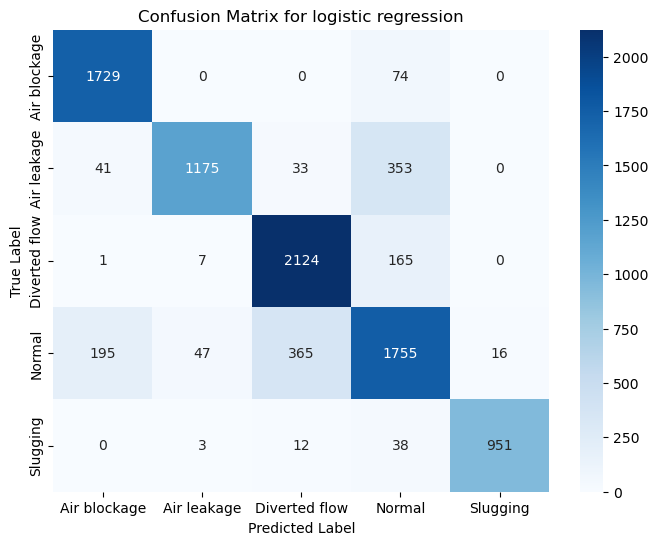

Logistic Regression Metrics:
Accuracy of the logistic regression classifier on the test set: 0.8514
Precision: 0.8560
Recall: 0.8514
F1 Score: 0.8503


In [23]:
# Performance of logistic regression classifier

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix for logistic regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average = 'weighted')
recall_lr = recall_score(y_test, y_pred_lr, average = 'weighted')
f1_lr = f1_score(y_test, y_pred_lr, average = 'weighted')

print("Logistic Regression Metrics:")
print(f"Accuracy of the logistic regression classifier on the test set: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")


In [24]:
# Classification Report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))


Classification Report for Logistic Regression:
               precision    recall  f1-score   support

 Air blockage       0.88      0.96      0.92      1803
  Air leakage       0.95      0.73      0.83      1602
Diverted flow       0.84      0.92      0.88      2297
       Normal       0.74      0.74      0.74      2378
     Slugging       0.98      0.95      0.96      1004

     accuracy                           0.85      9084
    macro avg       0.88      0.86      0.87      9084
 weighted avg       0.86      0.85      0.85      9084



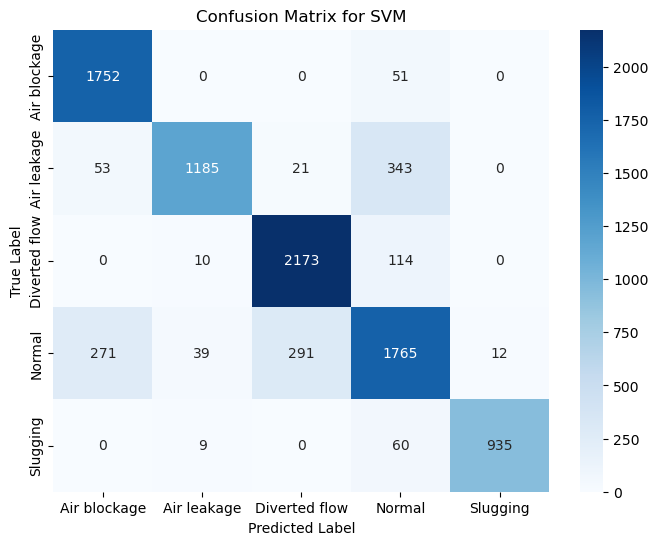


Support Vector Machine Metrics:
Accuracy: 0.8597534125935711
Precision: 0.8639
Recall: 0.8598
F1 Score: 0.8581


In [25]:
# Performance of SVM classifier
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average = 'weighted')
recall_svm = recall_score(y_test, y_pred_svm, average = 'weighted')
f1_svm = f1_score(y_test, y_pred_svm, average = 'weighted')

print("\nSupport Vector Machine Metrics:")
print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")

In [26]:
# Classification Report
print("\nClassification Report for Support Vector Machine:")
print(classification_report(y_test, y_pred_svm))


Classification Report for Support Vector Machine:
               precision    recall  f1-score   support

 Air blockage       0.84      0.97      0.90      1803
  Air leakage       0.95      0.74      0.83      1602
Diverted flow       0.87      0.95      0.91      2297
       Normal       0.76      0.74      0.75      2378
     Slugging       0.99      0.93      0.96      1004

     accuracy                           0.86      9084
    macro avg       0.88      0.87      0.87      9084
 weighted avg       0.86      0.86      0.86      9084

